## Finding Your Way In The City (Graph Edition)
In this notebook your attention will shift from grids to graphs. At least for search ... 

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.

In [1]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1
# import pkg_resources
# pkg_resources.require("networkx==2.1")

    100% |████████████████████████████████| 1.6MB 13.2MB/s ta 0:00:01 5% |█▉                              | 92kB 4.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /root/.cache/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e
Successfully built networkx
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
pomegranate 0.9.0 has requirement networkx<2.0,>=1.8.1, but you'll have networkx 2.1 which is incompatible.
moviepy 0.2.3.2 has requirement decorator==4.0.11, but you'll have decorator 4.4.1 which is incompatible.
ipywidgets 7.0.5 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.1.0 which is incompatible.


In [2]:
import networkx as nx
nx.__version__

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid_and_edges
import numpy.linalg as LA
%matplotlib inline 

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ..., 
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [6]:
start_ne = (25,  100)
goal_ne = (750., 370.)

In [7]:
# Static drone altitude (metres)
drone_altitude = 5
safety_distance = 3

In [8]:
# This is now the routine using Voronoi
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print(len(edges))

1895


Plot the edges on top of the grid along with start and goal locations.

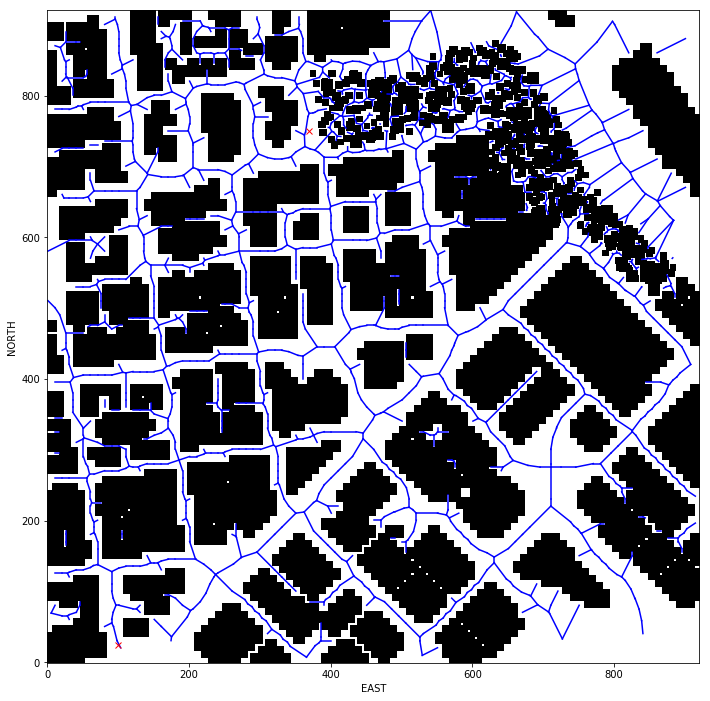

In [9]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

We now have a graph, well at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph. **NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms.

**NOTE:** In the initial import above it was imported with the `nx` alias.

You're encouraged to read the documentation but here's a super quick tour:

1. Create a graph:

```
G = nx.Graph()
```

2. Add an edge:

```
p1 = (10, 2.2)
p2 = (50, 40)
G = nx.add_edge(p1, p2)
```

3 Add an edge with a weight:

```
p1 = (10, 2.2)
p2 = (50, 40)
dist = LA.norm(np.array(p2) - np.array(p1))
G = nx.add_edge(p1, p2, weight=dist)
```

In [10]:
# TODO: create the graph with the weight of the edges
# set to the Euclidean distance between the points
G = nx.Graph()
for e in edges:
    p1 = e[0]
    p2 = e[1]
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)

You need a method to search the graph, and you'll adapt A* in order to do this. The notable differences being the actions are now the outgoing edges and the cost of an action is that weight of that edge.

In [11]:
from queue import PriorityQueue

def heuristic(n1, n2):
    #TODO: define a heuristic
    return ((n2[0] - n1[0])**2 + (n2[1] - n1[1])**2)**0.5

###### THIS IS YOUR OLD GRID-BASED A* IMPLEMENTATION #######
###### With a few minor modifications it can work with graphs! ####
#TODO: modify A* to work with a graph
def a_star(graph, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False

    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for adj in graph.adj[current_node]:
                edge = graph.edges[current_node, adj]
                branch_cost = current_cost + edge['weight']
                queue_cost = branch_cost + h(adj, goal)
                if adj not in visited:
                    visited.add(adj)
                    branch[adj] = (branch_cost, current_node, edges)
                    queue.put((queue_cost, adj))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


### Solution

This solution consists of two parts:

1. Find the closest point in the graph to our current location, same thing for the goal location.
2. Compute the path from the two points in the graph using the A* algorithm.
3. Feel free to use any of the path pruning techniques to make the path even smaller! 
4. Plot it up to see the results!

### TODO: Write your solution!

[our solution](/notebooks/Graph-Search-Solution.ipynb)

(25, 100) (750, 370)
[  20.7611  103.2685] [ 748.71871888  364.41446809]
Found a path.
89 [(20.761099999999999, 103.26850000000002), (30.761099999999999, 98.268500000000017), (50.761099999999999, 93.268500000000017), (55.761099999999999, 90.768500000000017), (60.761099999999999, 90.768500000000017), (70.761099999999999, 92.768500000000017), (80.761099999999999, 96.768500000000017), (90.761099999999999, 92.768500000000017), (100.7611, 90.768500000000017), (128.2611, 90.768500000000017), (133.2611, 100.76850000000002), (135.7611, 110.76850000000002), (135.7611, 130.76850000000002), (138.2611, 140.76850000000002), (140.7611, 145.76850000000002), (140.7611, 155.76850000000002), (143.2611, 160.76850000000002), (145.7611, 170.76850000000002), (145.7611, 209.10183333333333), (138.7611, 220.76849999999999), (130.7611, 230.76849999999999), (124.09443333333334, 237.43516666666667), (126.47538571428569, 240.76849999999999), (138.94291818181819, 262.58668181818183), (148.03382727272728, 273.495772

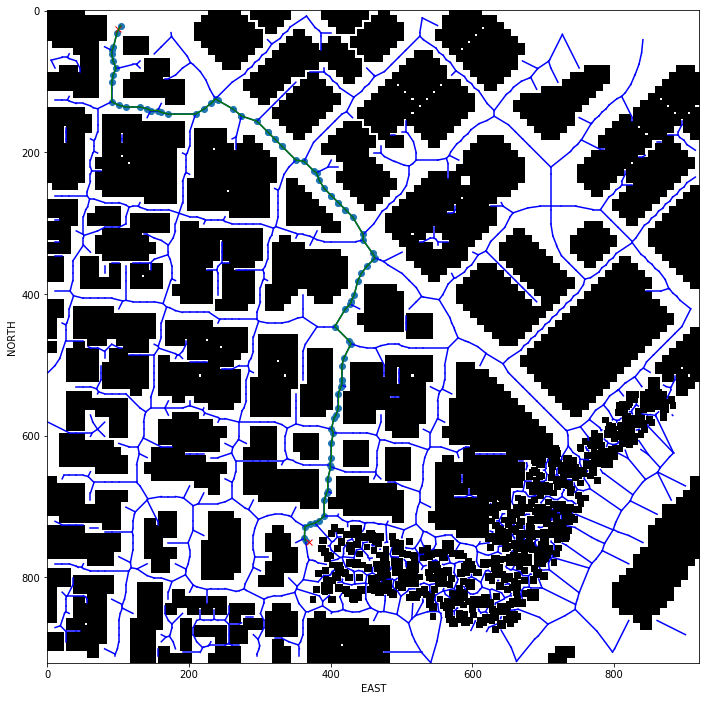

In [12]:
def find_start_goal(points, start, goal):
    # TODO: find start and goal on graph
    start_min_dist = np.linalg.norm(np.array(start) - np.array(points), axis=1).argmin()
    near_start = np.array(points)[start_min_dist]
    goal_min_dist = np.linalg.norm(np.array(goal) - np.array(points), axis=1).argmin()
    near_goal = np.array(points)[goal_min_dist]
    return near_start, near_goal

def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_check(p1, p2, p3):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
        
    return pruned_path


if __name__ == '__main__':
    filename = 'colliders.csv'
    data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
    start_ne = (25, 100)
    goal_ne = (750, 370)
    drone_altitude = 5
    safety_distance = 3
    grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
    plt.imshow(grid, origin='upper', cmap='Greys')
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    plt.plot(start_ne[1], start_ne[0], 'rx')
    plt.plot(goal_ne[1], goal_ne[0], 'rx')
    plt.xlabel('EAST')
    plt.ylabel('NORTH')

    G = nx.Graph()
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        dist = LA.norm(np.array(p2) - np.array(p1))
        G.add_edge(p1, p2, weight=dist)
    skel_start, skel_goal = find_start_goal(G.nodes, start_ne, goal_ne)

    print(start_ne, goal_ne)
    print(skel_start, skel_goal)

    path, cost = a_star(G, heuristic, tuple(skel_start), tuple(skel_goal))

    pruned_path = prune_path(path)
    print(len(pruned_path), pruned_path)
    if pruned_path is not None:
        pp = np.array(pruned_path)
        plt.plot(pp[:, 1], pp[:, 0], 'g')
        plt.scatter(pp[:, 1], pp[:, 0])

    plt.show()